# Render your design to Ansys

## Prerequisite
You need to have Ansys installed locally (any version) - at the time of this notebook, Ansys is only supported in Windows.

## 1. Create the design in Metal
#### 1.1 Preload libraries and classes, then open Metal
Let's start by importing all the key libraries and classes, and opening Metal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, MetalGUI
from qiskit_metal import Dict, Headings

In [3]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
QAnsysRenderer.default_options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'ansys_file_extension': '.aedt',
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [4]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

#### 1.2 Prepare a design consisting of 4 qubits and 4 CPWs
First we import the necessary components and change key global variables to the desired size.

In [5]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [6]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

Let's create the 4-Qubit-4-CPWs design in one shot. Feel free to break the cell below into subcells if you would like to more closely follow the layout generation.

In [7]:
# Enable overwrite, so that we can re-un this cell multiple times without incurring object name collisions
design.overwrite_enabled = True

# We now define the same custom options for all the transmons.
# We only list the options we intend to modify with respect to the default values
options = Dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 3 connection_pads
    connection_pads=Dict(
        a = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

# Create the 4 transmons
q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

# Now we do the same for the CPWs
options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

# We define a handy method to shorten the number of line of code necessary to define the 4 CPW
def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

# Create the 4 CPWs
asym = 140
cpw1 = connect('cpw1', 'Q1', 'c', 'Q2', 'b', '5.6 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'b', 'Q2', 'c', '5.7 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'c', 'Q4', 'b', '5.6 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q4', 'c', '5.7 mm', f'-{asym}um', flip=True)

# Render the entire design to the Qiskit Metal GUI
gui.rebuild()
gui.autoscale()

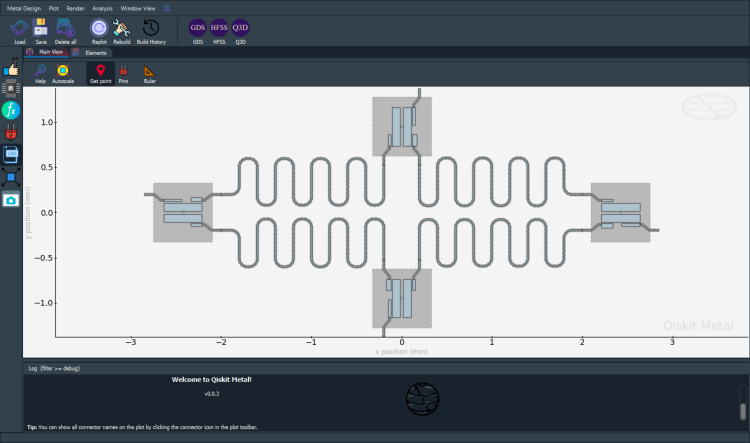

In [8]:
gui.screenshot()

## 2. Render into Ansys HFSS
The Ansys HFSS renderer was instantiated during the boot of Qiskit Metal. Let's create a short handle to refer to it in the rest of this notebook.

In [9]:
fourq_hfss = design.renderers.hfss

#### 2.1 Setup an Ansys project
To setup the project **manually**, follow these instructions:
1. Launch `ANSYS Electronics Desktop yyyy Rx` (from your Windows Start menu).
2. Create a new Ansys project by clicking on the `New` icon at the top left. (or open an existing project)

Alternatively, you can **automatically** set up the project by executing the following two cells. Make sure to wait after executing the first cell for Ansys to completely open. Only then execute the second cell.

Note about Ansys version: open_ansys() will look by default for the 2020 R2 version of Ansys. You can easily reroute it to your Ansys of choice by providing the name of the environment variable that contains the path (path_env) or the path itself (path)

In [10]:
fourq_hfss.open_ansys()   # this opens Ansys 2020 R2 if present
# fourq_hfss.open_ansys(path_var='ANSYSEM_ROOT211')
# fourq_hfss.open_ansys(path='C:\Program Files\AnsysEM\AnsysEM20.2\Win64')
# fourq_hfss.open_ansys(path='../../../Program Files/AnsysEM/AnsysEM20.2/Win64')

NOTE: A new project should have automatically opened with the execution of the cell above. If not, uncomment the cell below and execute it. You can also load an existing project by passing the project information to the `connect_ansys()`.

In [11]:
# fourq_hfss.new_ansys_project()

#### 2.2 Connect the Metal renderer with the Ansys project
Open either a new or existing design based on default options

In [12]:
fourq_hfss.connect_ansys()
# fourq_hfss.connect_ansys('C:\\project_path\\', 'Project1')  # Example of opening a saved project

INFO 11:10AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:10AM [load_ansys_project]: 	Opened Ansys App
INFO 11:10AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 11:10AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project15
INFO 11:10AM [connect_design]: No active design found (or error getting active design).
INFO 11:10AM [connect]: 	 Connected to project "Project15". No design detected


You can also indicate, using the optional parameters, whether you intend to open and use a previously saved project. <br>
Make sure that the saved project contains at least one design, or the method will produce a warning

#### 2.3 Setup an Ansys HFSS design
You can either create a new design or select and use an old one.

To **create** a new design **manually**, go to the Ansys GUI and follow these instructions:
1. Select the project from the leftmost menu in the Ansys GUI.
2. Go into the menu `Project` and select `Insert HFSS Design`.
3. Change the HFSS design to either eigenmode or modal by right-clicking on the HFSSdesign1 that just got created inside your project (left panel) and then selecting: `Solution Type...`.

To **create** a new eigenmode design **automatically**, execute the following cell<br>
The design will be added to the project that was active when the command `fourq_hfss.connect_ansys()` was executed.
Note: If a design named `HFSSTransmonQubit` already exists in the project, a new design will be created, with the name suffixed with an incremental integer: `HFSSTransmonQubit1`, `HFSSTransmonQubit2`, etc.

In [13]:
fourq_hfss.add_eigenmode_design("HFSSMetalEigenmode")

INFO 11:10AM [connect_design]: 	Opened active design
	Design:    HFSSMetalEigenmode [Solution type: Eigenmode]
WARNING 11:10AM [connect_setup]: 	No design setup detected.
WARNING 11:10AM [connect_setup]: 	Creating eigenmode default setup.
INFO 11:10AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


To **create** a new modal design **automatically**, execute the following cell instead

In [14]:
fourq_hfss.add_drivenmodal_design("HFSSMetalDrivenModal")

INFO 11:10AM [connect_design]: 	Opened active design
	Design:    HFSSMetalDrivenModal [Solution type: DrivenModal]
WARNING 11:10AM [connect_setup]: 	No design setup detected.
WARNING 11:10AM [connect_setup]: 	Creating drivenmodal default setup.
INFO 11:10AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


To **select** an existing design, you can follow one of three ways:
* re-running the `fourq_hfss.connect_ansys(*with parameters*)`, this time specifying which design to connect to (see section 2.2)
* manually activating the design from the Ansys GUI. You will find the list of designs in the leftmost panel, and you can activate them with a double click. After this, re-run the `fourq_hfss.connect_ansys()` *without parameters*.
* use methods: activate_eigenmode_design() or activate_drivenmodal_design().  If the design name exists, it will be added, but no integer will be added to the suffix. If the design name does not exist, then it will be added to the project.

Let's illustrate the **automated** method to select an existing design. The following two cells will switch between the eigenmode and the modal designs we just created in the last two cells above, or it will create them if you did not run the previous cells:

In [15]:
fourq_hfss.activate_eigenmode_design("HFSSMetalEigenmode")

INFO 11:10AM [connect_design]: 	Opened active design
	Design:    HFSSMetalEigenmode [Solution type: Eigenmode]


In [16]:
fourq_hfss.activate_drivenmodal_design("HFSSMetalDrivenModal")

INFO 11:10AM [connect_design]: 	Opened active design
	Design:    HFSSMetalDrivenModal [Solution type: DrivenModal]


#### 2.4 Render some component from the Metal design

Find below several rendering examples. You can choose to only execute one of them if you are just browsing this notebook.

Notice how we explicitly clear the design before re-rendering. Indeed `render_design()` only adds shapes to the Ansys design. Re-rendering the same shapes will cause violations.

In [17]:
fourq_hfss.render_design()  # entire Metal design.

In [18]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design(['Q1'], [('Q1', 'b'), ('Q1', 'c')])  # single qubit with 2 endcaps.

In [19]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design(['Q1', 'cpw1', 'Q2'], [('Q1', 'b'), ('Q2', 'c')])  # 2 qubits and 2 endcaps, one per qubit.

For Driven-Modal analysis, we can also add terminations. In the example below we render 1 qubit with 1 endcap and 1 port with a 70 Ohm termination.

In [20]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design(['Q2'], [('Q2', 'a')], [('Q2', 'b', '70')])

In the previous examples, rendering area dimenstions is determined by the size of the selected geometries, with some buffer.

For a more accurate control of the chip size, you need to disable the buffering as below. This will use `design._chips['main']['size']` to determine the rendering area dimensions.

In [21]:
design._chips['main']['size']['size_y'] = '6mm'

In [22]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design([], [], box_plus_buffer=False)

You can also modify the chip size directly by updating `design._chips['main']['size']`. Example below.

NOTE: we purposfully make the chip size smaller than the size of the geometry. This will cause a warning to show which will need to be fixed by the user intending to conduct a valid analysis.

In [23]:
fourq_hfss.clean_active_design()
design._chips['main']['size']['size_x'] = '4mm'
fourq_hfss.render_design([], [], box_plus_buffer=False)
#    Return back to original size, for the remainder of the notebook
design._chips['main']['size']['size_x'] = '6mm'

#### 2.5 Create of select a setup
This section is only needed if you plan to execute an analysis. This topic will be covered in the tutorials in chapter 6.

To **select** a setup for the active design, you can use `activate_drivenmodal_setup()` or `activate_eigenmode_setup()`. If the setup exists, the QRenderer will reference the setup, otherwise, will make a new setup with the name give.  If no name given, the default name of "Setup" will be used. Below the example for eigenmode.

In [24]:
fourq_hfss.activate_eigenmode_design("HFSSMetalEigenmode")

INFO 11:13AM [connect_design]: 	Opened active design
	Design:    HFSSMetalEigenmode [Solution type: Eigenmode]


In [25]:
fourq_hfss.activate_eigenmode_setup('SetupNEW')

**Finally** disconnect the Metal renderer from the Ansys session.

NOTE: This is needed every time before re-connecting. If you do not disconnect explicitly, you might not be able to close the Ansys GUI later.

In [26]:
fourq_hfss.disconnect_ansys()

Warning! 15 COM references still alive
Ansys will likely refuse to shut down


## 3. Render into Ansys Q3D
The Ansys Q3D renderer was instantiated during the boot of Qiskit Metal. Let's create a short handle to refer to it in the rest of this notebook.

In [27]:
fourq_q3d = design.renderers.q3d

#### 3.1 Setup an Ansys project
Skip this section if ansys is already open. See section 2.1 in this notebook for additional details and options.

In [28]:
fourq_q3d.open_ansys()

#### 3.2 Connect the Q3D renderer with the Ansys project
Open either a new or existing design based on default options. See section 2.2 in this notebook for details and options.

In [29]:
fourq_q3d.connect_ansys()
# fourq_q3d.connect_ansys('C:\\project_path\\', 'Project1')  # Example of opening a saved project

INFO 11:13AM [connect_project]: Connecting to Ansys Desktop API...
INFO 11:13AM [load_ansys_project]: 	Opened Ansys App
INFO 11:13AM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 11:13AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project15
INFO 11:13AM [connect_design]: 	Opened active design
	Design:    HFSSMetalEigenmode [Solution type: Eigenmode]
INFO 11:13AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:13AM [connect]: 	Connected to project "Project15" and design "HFSSMetalEigenmode" 😀 



#### 3.3 Setup an Ansys Q3D design
You can either create a new design or select and use an old one.

To **create** a new design **manually**, go to the Ansys GUI and follow these instructions:
1. Select the project from the leftmost menu in the Ansys GUI.
2. Go into the menu `Project` and select `Insert Q3D Extractor Design`.

To **create** a new Q3D design **automatically**, execute the following cell.<br>
Note: If a design named `Q3dMetalDesign` already exists in the project, a new design will be created, with the name suffixed with an incremental integer: `Q3dMetalDesign1`, `Q3dMetalDesign2`, etc.

In [30]:
fourq_q3d.add_q3d_design("Q3dMetalDesign")

INFO 11:13AM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesign [Solution type: Q3D]
WARNING 11:13AM [connect_setup]: 	No design setup detected.
WARNING 11:13AM [connect_setup]: 	Creating Q3D default setup.
INFO 11:13AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


To **select** an existing design, means to activate an Ansys design and connect to it. You can follow one of three ways:
* re-running the `fourq_q3d.connect_ansys(*with parameters*)`, this time specifying which design to connect to (see section 2.3)
* manually activating the design from the Ansys GUI. You will find the list of designs in the leftmost panel, and you can activate them with a double click. After this, re-run the `fourq_q3d.connect_ansys()` *without parameters*.
* use method: activate_q3d_design().  If the design name exists, it will be added, but no integer will be added to the suffix. If the design name does not exist, then it will be added to the project.

Let's illustrate the **automated** method to select an existing design. The first of the two cells below will create a new design because the name does not corrispond to any design in the project. The second cell will return to the previously created design.

In [31]:
fourq_q3d.activate_q3d_design("Q3dMetalDesignNEW")

11:13AM 59s WARNING [activate_q3d_design]: The name=Q3dMetalDesignNEW was not in active project.  A new design will be inserted to the project.  Names in active project are: 
['Q3dMetalDesign', 'HFSSMetalEigenmode', 'HFSSMetalDrivenModal'].  
INFO 11:14AM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesignNEW [Solution type: Q3D]
WARNING 11:14AM [connect_setup]: 	No design setup detected.
WARNING 11:14AM [connect_setup]: 	Creating Q3D default setup.
INFO 11:14AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


In [32]:
fourq_q3d.activate_q3d_design("Q3dMetalDesign")

INFO 11:14AM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesign [Solution type: Q3D]


#### 3.4 Render some component from the Metal design

Find below several rendering examples. You can choose to only execute one of them if you are just browsing this notebook.

Notice how we explicitly clear the design before re-rendering. Indeed `render_design()` only adds shapes to the Ansys design. Re-rendering the same shapes will cause violations.

In [33]:
fourq_q3d.render_design()  # entire Metal design.

In [34]:
fourq_q3d.clean_active_design()
fourq_q3d.render_design(['Q1'], [('Q1', 'b'), ('Q1', 'c')])  # single qubit with 2 endcaps.

In [35]:
fourq_q3d.clean_active_design()
fourq_q3d.render_design(['Q1', 'cpw1', 'Q2'], [('Q1', 'b'), ('Q2', 'c')])  # 2 qubits and 2 endcaps, one per qubit.

In the previous examples, rendering area dimenstions is determined by the size of the selected geometries, with some padding.

For a more accurate control of the chip size, you need to disable the buffering as below. This will use `design._chips['main']['size']` to determine the rendering area dimensions.

In [36]:
fourq_q3d.clean_active_design()
fourq_q3d.render_design([], [], box_plus_buffer=False)

You can also modify the chip size directly by updating `design._chips['main']['size']`. Example below:

In [37]:
fourq_q3d.clean_active_design()
design._chips['main']['size']['size_y'] = '4mm'
fourq_q3d.render_design([], [], box_plus_buffer=False)
#    Return back to original size, for the remainder of the notebook
design._chips['main']['size']['size_y'] = '6mm'

#### 3.5 Create of select a setup
This section is only needed if you plan to execute an analysis. This topic will be covered in the tutorials in chapter 6.

To **select** a setup for the active design, you can use `activate_q3d_setup()`. If the setup exists, the QRenderer will reference the setup, otherwise, will make a new setup with the name give.  If no name given, the default name of "Setup" will be used.

In [38]:
fourq_q3d.activate_q3d_setup("SetupNEW")

**Finally** disconnect the Metal renderer from the Ansys session. You will not be able to close Ansys without executing this.

In [39]:
fourq_q3d.disconnect_ansys()

Warning! 15 COM references still alive
Ansys will likely refuse to shut down


If you want to close the Metal GUI, uncomment the following cell

In [40]:
# gui.main_window.close()

## References - Miscellaneous pyEPR/Ansys commands
The following commands are for reference only to better understand how the backend code works. They're not meant to be run directly in this notebook as part of the tutorial.

import pyEPR as epr

Connect to Ansys directly from notebook:

pinfo = epr.ProjectInfo(project_path = None, 
                        project_name = None,
                        design_name  = None)
modeler = pinfo.design.modeler

Access methods within HfssDesign class in pyEPR:

epr.ansys.HfssDesign.create_dm_setup
epr.ansys.HfssDesign.create_q3d_setup

Get project and design names:

pinfo.project_name
design._design.GetName()

Filter qgeometry table:

full_table = design.qgeometry.tables['poly']
mask = full_table['subtract'] == False
table = full_table[mask]

Draw centered rectangles:

bigsquare = modeler.draw_rect_center([0, 0, 0], x_size=8, y_size=8, name='bigsquare')
topright = modeler.draw_rect_center([2, 2, 0], x_size=2, y_size=2, name='topright')

Subtracting shapes:

modeler.subtract('bigsquare', ['topright'])

Draw centered box:

modeler.draw_box_center([0, 0, 0], [1, 2, 3])

Draw closed polygon:

trianglepts = [[-1, 5, 0], [1, 5, 0], [0, 7, 0]]
modeler.draw_polyline(trianglepts, closed=True)

Draw polyline:

smallpts = [[2.85, 0, 0], [3.15, 0, 0]]
modeler.draw_polyline(smallpts, closed=False)

Sweep one polyline with another:

modeler._sweep_along_path('Polyline8', 'Polyline7')